<a href="https://colab.research.google.com/github/krislars/AA_Tau_Covey/blob/master/Kristen/NGC_6569/tightpm_10000steps_0pm0ext_pad0.5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installs

In [ ]:
!pip install dust_extinction

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 445 kB 4.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for dust-extinction: filename=dust_extinction-1.1-py3-none-any.whl size=430960 sha256=a55754722d9688bb7792def62e5e3173c35c57dac8aa7f5632f3c45dc4ede740
  Stored in directory: /root/.cache/pip/wheels/8d/16/00/8f379f735817d9336f50ceb4633a22d7f37637ecb0730e6bdf
Successfully built dust-extinction


I don't know why this install must happen first.  Is one of the packages also using dust_extinction?

In [ ]:
from dust_extinction.parameter_averages import F19

In [ ]:
!pip install isochrones

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76 kB 2.6 MB/s 
     |████████████████████████████████| 46 kB 3.5 MB/s 
     |████████████████████████████████| 4.5 MB 15.3 MB/s 
     |████████████████████████████████| 832 kB 63.4 MB/s 
     |████████████████████████████████| 48 kB 4.9 MB/s 
     |████████████████████████████████| 4.1 MB 47.7 MB/s 
  Created wheel for isochrones: filename=isochrones-2.1-py3-none-any.whl size=93781 sha256=6cb9f28c1b3d0c59bb62ee0f102e7f02957176235f952b5bc1e3650851d5c4c8
  Stored in directory: /root/.cache/pip/wheels/06/a3/0b/590c2fab4d7e7bdb40428104b54d99f3d0aa4a78e4a8ad7f85
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5050 sha256=3cbe6ecfd9f24f2bbfa7e379a1d925a87f38419cbcf9021f08bccd0cace1ba0a
  Stored in directory: /root/.cache/pip/wheels/12/1c/38/0def51e15add93bff3f4bf9c248b94db0839b980b8535e72a0
  Created wheel for configobj: fil

In [ ]:
!pip install speclite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 892 kB 4.0 MB/s 
     |████████████████████████████████| 316 kB 61.1 MB/s 
  Created wheel for speclite: filename=speclite-0.16-py3-none-any.whl size=366405 sha256=10c34d346810529f193c61cd7949bd96a23165fb1d541d2176560a543df0583f
  Stored in directory: /root/.cache/pip/wheels/f6/a4/bd/2a654fc354d5dd58cd1873ee8abcd440f6ac1dcaa2f742bf06
Successfully built speclite
  Attempting uninstall: pluggy
    Found existing installation: pluggy 0.7.1
    Uninstalling pluggy-0.7.1:
      Successfully uninstalled pluggy-0.7.1
  Attempting uninstall: pytest
    Found existing installation: pytest 3.6.4
    Uninstalling pytest-3.6.4:
      Successfully uninstalled pytest-3.6.4


# Imports

In [ ]:
from google.colab import drive
import numpy as np
from matplotlib import pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import ascii,fits
from astropy.table import Table,MaskedColumn
from isochrones.mist import MIST_Isochrone
import emcee
import corner
import speclite.filters

# Lit values

Distance from Sun:	10530 ± 260 pc (HB database)

Age: 12 Gy = 10^10.08 (HB database)

Half-mass radius:	3.85 pc (HB database)

E(B-V) = 0.49 (HB database) so AV = 1.5

# AAO cut from Andrea

> When we observed extra-tidal stars around NGC 6569 using the AAT, we made a few cuts to select the BDBS potential extra-tidal star candidates.  This was our criteria:
>
> 1.). Star has to be within a 0.95 degree radius from the center of the cluster.  
>
> 2.). Star has to have a proper motion within 1 mas/yr in pm_ra and within 1.5 mas/yr in pm_dec of the cluster proper motion.  We assumed a cluster proper motion of (pm_ra, pm_dec) = (-4.125 mas/yr, -7.354 mas/yr) So basically, any BDBS star with pm_ra = -4.125 pm 1 and pm_dec = -7.354 pm 1.5 was retained. 
>
> 3.). We selected only stars with BDBS u-magnitudes that have an uncertainty < 0.04 mag, and selected only stars with BDBS g-mag < 35 and BDBS i-mag < 35.


# Read files

I've set up this notebook to automatically mount my drive.  Otherwise, uncomment lines below.

In [ ]:
# from google.colab import drive
# drive.mount('/gdrive')
# %cd /gdrive
%cd 'drive'
%cd 'My Drive'
%cd 'Colab Notebooks'

/content/drive
/content/drive/My Drive
/content/drive/My Drive/Colab Notebooks


NGC6569/N6569_gaia_.95_asteca.csv = raw data and extinction corrections

NGC6569/n6569_rz.dat =  extinction-corrected data, with r-z color

difference between the two is 1e-9 on average

NGC6569/n6569_rz/n6569_rz.dat = same, with sel and memb_probs


In [ ]:
output = ascii.read('NGC6569/n6569_rz/n6569_rz.dat')
output

bbdbs_id,ra_gaia,dec_gaia,u0,uerr,g0,gerr,r0,rerr,i0,ierr,z0,zerr,y0,yerr,rmz0,rmzerr,parallax,parallax_error,pmra,pmra_err,pmdec,pmdec_err,sel,memb_probs
str10,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64
b113141010,272.8236489284066,-31.825760093419454,19.849,0.00800000037997961,18.595,0.008999999612569809,18.197,0.012000000104308128,18.049,0.027000000700354576,17.973,0.003000000026077032,17.797,0.03200000151991844,0.224,0.012000000104308128,0.49148091330393,0.24720033,-4.923585793007333,0.26588166,-7.497422943831253,0.20272277,-1,0.0
b113141655,272.82385799450293,-31.80746292708884,19.087,0.017000000923871994,17.586,0.008999999612569809,17.17,0.0020000000949949026,17.108,0.07199999690055847,17.009,0.00800000037997961,16.883,0.01600000075995922,0.161001,0.0020000000949949026,0.015628341263849765,0.14849877,-4.277027261787843,0.16946939,-7.0659008592028965,0.12937388,-1,0.0
b113143546,272.8244953727538,-31.815824530640022,19.345,0.010999999940395355,18.184,0.014000000432133675,17.929,0.05999999865889549,17.894,0.08500000089406967,17.694,0.03799999877810478,17.642,0.004999999888241291,0.235001,0.05999999865889549,0.47045704753991086,0.18447089,-2.2197698280172644,0.19896723,-6.529358538568835,0.15325034,-1,0.0
b113144483,272.8247892243031,-31.840072902631984,19.612,0.013000000268220901,18.421,0.009999999776482582,18.206,0.057999998331069946,18.04,0.028999999165534973,18.02,0.03200000151991844,17.952,0.02800000086426735,0.185999,0.057999998331069946,0.06346120588598783,0.26775873,-2.225229123257765,0.2532076,-7.406194445520015,0.20245771,-1,0.0
b113144901,272.8249213779338,-31.84352537718205,17.759,0.004999999888241291,16.705,0.006000000052154064,16.728,0.019999999552965164,16.893,0.05000000074505806,16.828,0.010999999940395355,16.81,0.0010000000474974513,-0.0999984,0.019999999552965164,0.32851449871951915,0.10326293,-2.6310301204954545,0.119397804,-5.36508146828024,0.08991535,-1,0.0
b113144907,272.8250500598343,-31.811192429398638,19.418,0.02500000037252903,18.081,0.02800000086426735,19.692,0.07699999958276749,17.223,0.03999999910593033,17.089,0.006000000052154064,19.06,0.05700000002980232,2.603,0.07699999958276749,0.2836301111249088,0.14693089,-3.3508988675664066,0.15728663,-5.981709240518061,0.11564678,-1,0.0
b113145046,272.82500816070245,-31.818955285840417,19.596,0.02199999988079071,18.386,0.008999999612569809,18.005,0.017000000923871994,17.917,0.028999999165534973,17.714,0.03099999949336052,17.788,0.03799999877810478,0.291001,0.017000000923871994,0.0666606425231788,0.20241079,-4.255819827321221,0.20927371,-8.539983066592114,0.15802456,-1,0.0
b113145121,272.8249865922924,-31.829632159688337,20.28,0.017999999225139618,18.705,0.00800000037997961,18.172,0.04399999976158142,18.01,0.05299999937415123,17.83,0.0010000000474974513,17.616,0.032999999821186066,0.342,0.04399999976158142,0.45730428821861263,0.22338016,-3.4033093644286248,0.23319809,-5.467844727223281,0.18173312,-1,0.0
b113146478,272.8254609658406,-31.837530105204095,19.045,0.013000000268220901,17.501,0.012000000104308128,17.085,0.035999998450279236,16.961,0.0010000000474974513,16.908,0.04800000041723251,16.752,0.014999999664723873,0.176998,0.035999998450279236,0.12434109973397593,0.10882321,-3.369287450469132,0.12543362,-5.7531098875339834,0.097640775,-1,0.0


In [ ]:
rawdat = ascii.read('NGC6569/N6569_gaia_.95_asteca.csv')
rawdat

genericid,ra,dec,umag,uerr,gmag,gerr,rmag,rerr,imag,ierr,zmag,zerr,ymag,yerr,Au,Ag,Ar,Ai,Az,Ay,bdbs_id,gaia_id,source_id,ra_gaia,ra_err,dec_gaia,dec_err,parallax,parallax_error,pmra,pmra_err,pmdec,pmdec_err,phot_g_mag
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
9,272.82365,-31.82573,20.917999267578125,0.00800000037997961,19.447999954223633,0.008999999612569809,18.822999954223633,0.012000000104308128,18.511999130249023,0.027000000700354576,18.32900047302246,0.003000000026077032,18.08099937438965,0.03200000151991844,1.069000005722046,0.8529999852180481,0.6259999871253967,0.46299999952316284,0.35600000619888306,0.2840000092983246,113141010,4048849108697080960,4048849108697080960,272.8236489284066,0.21656652,-31.825760093419454,0.19278045,0.49148091330393,0.24720033,-4.923585793007333,0.26588166,-7.497422943831253,0.20272277,18.876898
24,272.82386,-31.80743,20.201000213623047,0.017000000923871994,18.475000381469727,0.008999999612569809,17.82200050354004,0.0020000000949949026,17.590999603271484,0.07199999690055847,17.3799991607666,0.00800000037997961,17.179000854492188,0.01600000075995922,1.1139999628067017,0.8889999985694885,0.6520000100135803,0.4830000102519989,0.3709999918937683,0.29600000381469727,113141655,4048849898847921280,4048849898847921280,272.82385799450293,0.14032608,-31.80746292708884,0.12722822,0.015628341263849765,0.14849877,-4.277027261787843,0.16946939,-7.0659008592028965,0.12937388,17.823154
64,272.8245,-31.8158,20.413999557495117,0.010999999940395355,19.03700065612793,0.014000000432133675,18.55500030517578,0.05999999865889549,18.35700035095215,0.08500000089406967,18.049999237060547,0.03799999877810478,17.926000595092773,0.004999999888241291,1.069000005722046,0.8529999852180481,0.6259999871253967,0.46299999952316284,0.35600000619888306,0.2840000092983246,113143546,4048849147285146368,4048849147285146368,272.8244953727538,0.16629444,-31.815824530640022,0.1480177,0.47045704753991086,0.18447089,-2.2197698280172644,0.19896723,-6.529358538568835,0.15325034,18.557129
83,272.8248,-31.84005,20.57900047302246,0.013000000268220901,19.19300079345703,0.009999999776482582,18.77199935913086,0.057999998331069946,18.458999633789062,0.028999999165534973,18.343000411987305,0.03200000151991844,18.208999633789062,0.02800000086426735,0.9670000076293945,0.7720000147819519,0.5659999847412109,0.4189999997615814,0.3230000138282776,0.25699999928474426,113144483,4048848666207986176,4048848666207986176,272.8247892243031,0.20215376,-31.840072902631984,0.19839893,0.06346120588598783,0.26775873,-2.225229123257765,0.2532076,-7.406194445520015,0.20245771,18.656208
93,272.82493,-31.8435,18.72599983215332,0.004999999888241291,17.476999282836914,0.006000000052154064,17.29400062561035,0.019999999552965164,17.312000274658203,0.05000000074505806,17.150999069213867,0.010999999940395355,17.066999435424805,0.0010000000474974513,0.9670000076293945,0.7720000147819519,0.5659999847412109,0.4189999997615814,0.3230000138282776,0.25699999928474426,113144901,4048848666248648192,4048848666248648192,272.8249213779338,0.09517766,-31.84352537718205,0.084767096,0.32851449871951915,0.10326293,-2.6310301204954545,0.119397804,-5.36508146828024,0.08991535,17.210413
94,272.82493,-31.81136,20.531999588012695,0.02500000037252903,18.969999313354492,0.02800000086426735,20.3439998626709,0.07699999958276749,17.70599937438965,0.03999999910593033,17.459999084472656,0.006000000052154064,19.356000900268555,0.05700000002980232,1.1139999628067017,0.8889999985694885,0.6520000100135803,0.4830000102519989,0.3709999918937683,0.29600000381469727,113144907,4048849903199400576,4048849903199400576,272.8250500598343,0.1260901,-31.811192429398638,0.110222526,0.2836301111249088,0.14693089,-3.3508988675664066,0.15728663,-5.981709240518061,0.11564678,18.157827
101,272.8249

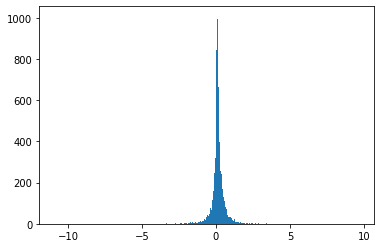

In [ ]:
plt.hist(rawdat['parallax'],bins=1000)
plt.show()

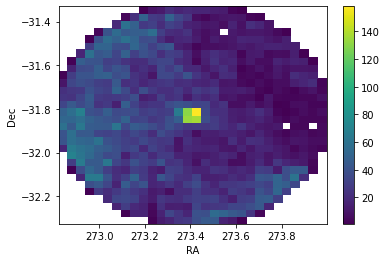

In [ ]:
plt.hist2d(rawdat['ra'],rawdat['dec'],bins=30,cmin=1)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.colorbar()
plt.show()
plt.show()

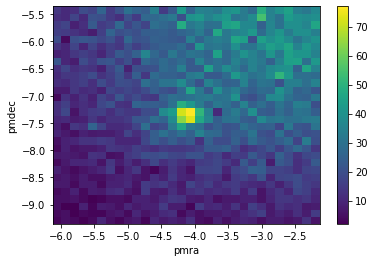

In [ ]:
plt.hist2d(rawdat['pmra'],rawdat['pmdec'],bins=30,cmin=1)
plt.xlabel('pmra')
plt.ylabel('pmdec')
plt.colorbar()
plt.show()
plt.show()

Proper motion cuts:

In [ ]:
# These are Andrea's cuts:
pmracut = (rawdat['pmra'] > (-4.125 - 1)) & (rawdat['pmra'] < (-4.125 + 1))
pmdeccut = (rawdat['pmdec'] > (-7.354 - 1.5)) & (rawdat['pmdec'] < (-7.354 + 1.5))
# This is just the cluster:
pmracut = (rawdat['pmra'] > (-4.125 - 3*.04125)) & (rawdat['pmra'] < (-4.125 + 3*.04125))
pmdeccut = (rawdat['pmdec'] > (-7.354 - 2*.07354)) & (rawdat['pmdec'] < (-7.354 + 2*.07354))
pmcut = pmracut & pmdeccut
sum(pmcut)

281

Photometry cuts:

In [ ]:
photcut = (rawdat['uerr'] < 0.04) & ((rawdat['gmag']-rawdat['Ag']) < 35.) & ((rawdat['imag']-rawdat['Ai']) < 35.)
cut = pmcut & photcut & (rawdat['zmag'] < 90.) # remove NANs 
sum(cut)

280

Are there any good parallax measurements?  No, only two stars with the parallax for 10 kpc and fractional error better than 0.2.

In [ ]:
# pxcut = cut & (rawdat['parallax_error']/rawdat['parallax'] < 0.2) & (rawdat['parallax_error']/rawdat['parallax'] > 0.0)
# plt.hist(rawdat['parallax'][pxcut],bins=np.arange(0,0.3,0.01))
# plt.show()

# CHOOSE BANDS HERE:

In [ ]:
band1 = 'r'
band2 = 'z'

# CMDs

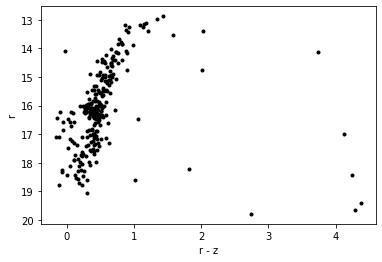

In [ ]:
plt.plot(output[band1+'0'][cut]-output[band2+'0'][cut],output[band1+'0'][cut],'k.')
plt.gca().invert_yaxis()
plt.xlabel(band1+' - '+band2)
plt.ylabel(band1)
plt.show()

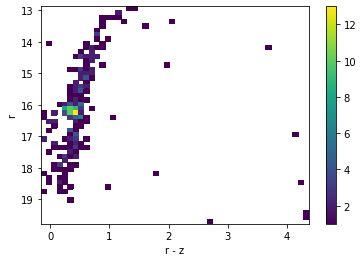

In [ ]:
plt.hist2d(output[band1+'0'][cut]-output[band2+'0'][cut],output[band1+'0'][cut],bins=50,cmin=1)
plt.gca().invert_yaxis()
plt.xlabel(band1+' - '+band2)
plt.ylabel(band1)
plt.colorbar()
plt.show()

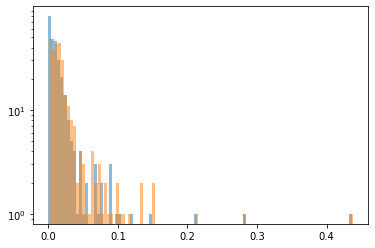

In [ ]:
plt.hist(output[band1+'err'][cut],alpha=0.5,bins=100)
plt.hist(((output[band1+'err'][cut])**2+(output[band2+'err'][cut])**2)**0.5,alpha=0.5,bins=100)
plt.yscale('log')
plt.show()

In [ ]:
output[band1+'err'][cut].min(),output[band2+'err'][cut].min()

(0.0, 0.0)

Must pad error, otherwise fits won't work.

# More cuts!

Arbitrary, to clean up the CMD before fitting

In [ ]:
# cleancut = ~((output['r0']>16.) & ((output['r0']-output['z0'])>1))
# cut = pmcut & photcut & (output['z0'] < 90.)  & cleancut

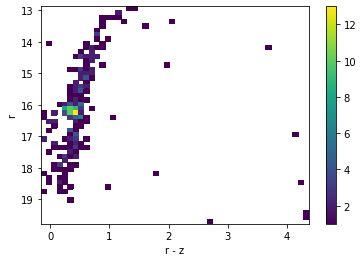

In [ ]:
plt.hist2d(output[band1+'0'][cut]-output[band2+'0'][cut],output[band1+'0'][cut],bins=50,cmin=1)
plt.gca().invert_yaxis()
plt.xlabel(band1+' - '+band2)
plt.ylabel(band1)
plt.colorbar()
plt.show()

# Isochrones

This first time the isochrones are used in a notebook, Colab has to download them.  Be patient, as it might take several minutes.

In [ ]:
# mist = MIST_Isochrone('ugriz')
mist = MIST_Isochrone(["DECam_u", "DECam_g", "DECam_r", "DECam_i", "DECam_z", "DECam_Y"])
# magnitudes are in the form filter_mag

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_name[Fe/H]'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


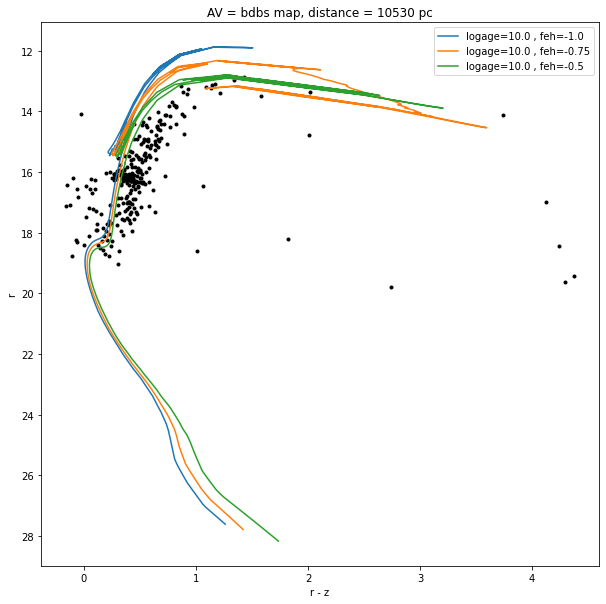

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(10,10))

plt.plot(output[band1+'0'][cut]-output[band2+'0'][cut],output[band1+'0'][cut],'k.')

for feh in [-1.0,-0.75,-0.5]:
    for logage in [10.0]:
        isoch = mist.isochrone(logage, feh, distance=10530, AV=0, eep_range=(200,1400))
        ax.plot(isoch['DECam_'+band1+'_mag']-isoch['DECam_'+band2+'_mag'],isoch['DECam_'+band1+'_mag'],
                 label='logage='+str(logage)+' , feh='+str(feh))

fig.gca().invert_yaxis()    
plt.xlabel(band1+' - '+band2)
plt.ylabel(band1)
ax.legend()
ax.set_title('AV = bdbs map, distance = 10530 pc')
fig.show()

## Initialize extinction curve:

In [ ]:
extcurve = F19(Rv=3.1)
decam = speclite.filters.load_filters('decam2014-*')
bands = ['u','g','r','i','z','Y']
leff = dict(zip(bands, decam.effective_wavelengths))
A1AV = extcurve(leff[band1])
A2AV = extcurve(leff[band2])
print(A1AV,A2AV)

0.8326270892160166 0.4848896110080301


# CMD isochrone fit

Switch distance from pc to kpc.


## Which data to fit? Random selection... no, now fit all with tighter pm constraints.

In [ ]:
# numstars = 4000
# choose = np.random.choice(len(output[cut]),numstars,replace=False)
choose = np.full(len(output[cut]),True)

## Which data to fit? Extinction corrected data

In [ ]:
datmag_raw = output[band1+'0'][cut][choose].value
datcol_raw = output[band1+'0'][cut][choose].value-output[band2+'0'][cut][choose].value
errmag_raw = output[band1+'err'][cut][choose].value
errcol_raw = ((output[band1+'err'][cut][choose].value)**2+(output[band2+'err'][cut][choose].value)**2)**0.5


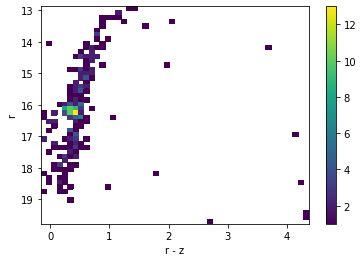

In [ ]:
plt.hist2d(datcol_raw,datmag_raw,bins=50,cmin=1)
plt.gca().invert_yaxis()
plt.xlabel(band1+' - '+band2)
plt.ylabel(band1)
plt.colorbar()
plt.show()

In [ ]:
# fig = corner.corner(np.vstack([datcol[datmag>18],datmag[datmag>18]]).T)

## Pad error:

This is the only way I can get the walkers to walk...

In [ ]:
pad = 0.5
errcol = errcol_raw + pad
errmag = errmag_raw + pad

## Set the added extinction:

Kyle, here is where we add the extinction to the data

In [ ]:
# Now add fake extinction with mean (loc) and random distribution width (scale)
# fakeAV = np.zeros(len(datmag))
aloc=0.0
ascale=0.0
fakeAV = np.random.normal(loc=aloc, scale=ascale, size=len(datmag_raw)) 
datmag = datmag_raw + fakeAV*A1AV
datcol = datcol_raw + fakeAV*(A1AV - A2AV)
avmax = fakeAV.max()

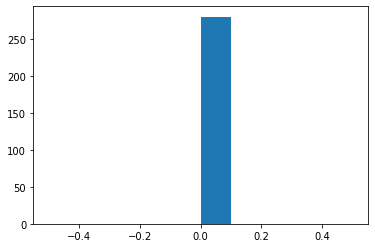

In [ ]:
plt.hist(fakeAV)
plt.show()

## Set up MCMC:

$$
p_i = \frac{1}{2\pi\sigma_{xi}\sigma_{yi}}\exp \left( -\frac{(x_i - mx_i)^2}{2\sigma_{xi}^2} - \frac{(y_i - my_i)^2}{2\sigma_{yi}^2} \right)
$$
where $x,y$ are data and $mx,my$ is the closest isochrone point.

$$
\begin{align}
\mathcal{L} & = \prod^N_i p_i \\
  & =  \prod^N_i \frac{1}{2\pi\sigma_{xi}\sigma_{yi}}\exp \left(-\frac{(x_i - mx_i)^2}{2\sigma_{xi}^2} \right) \exp \left(- \frac{(y_i - my_i)^2}{2\sigma_{yi}^2} \right)
\end{align}
$$

Taking the log of each side,
$$
\begin{align}
\ln\mathcal{L} & = \sum_i^N \ln \frac{1}{2\pi\sigma_{xi}\sigma_{yi}} - \frac{1}{2}\sum_i^N \left( \frac{(x_i - mx_i)^2}{\sigma_{xi}^2} +  \frac{(y_i - my_i)^2}{\sigma_{yi}^2} \right) \\
& = - \sum_i^N (\ln 2\pi + \ln \sigma_{xi} + \ln \sigma_{yi}) - \frac{1}{2}\sum_i^N \left( \frac{(x_i - mx_i)^2}{\sigma_{xi}^2} +  \frac{(y_i - my_i)^2}{\sigma_{yi}^2} \right) \\
& = - N \ln 2\pi - \sum_i^N (\ln \sigma_{xi} + \ln \sigma_{yi}) - \frac{1}{2}\sum_i^N \left( \frac{(x_i - mx_i)^2}{\sigma_{xi}^2} +  \frac{(y_i - my_i)^2}{\sigma_{yi}^2} \right)
\end{align}
$$
which is
$$
\ln \mathcal{L} = - 1.84 N - \sum_i^N (\ln \sigma_{xi} + \ln \sigma_{yi}) - \frac{1}{2}\sum_i^N \left( \frac{(x_i - mx_i)^2}{\sigma_{xi}^2} +  \frac{(y_i - my_i)^2}{\sigma_{yi}^2} \right)
$$


In [ ]:
def log_likelihood(theta, datcol, datmag, errcol, errmag):
    a, m, dmod = theta
    isoch = mist.isochrone(np.log10(a)+9.0, m, distance=10.0**(dmod/5 + 1), eep_range=(200,1400))
    isocol=isoch['DECam_'+band1+'_mag']-isoch['DECam_'+band2+'_mag']
    isomag=isoch['DECam_'+band1+'_mag']
    deltamag = np.broadcast_to(datmag,(len(isomag),len(datmag))) - np.transpose(np.broadcast_to(isomag,(len(datmag),len(isomag))))
    deltacol = np.broadcast_to(datcol,(len(isocol),len(datcol))) - np.transpose(np.broadcast_to(isocol,(len(datcol),len(isocol))))
    metric2 = np.amin((deltamag/errmag)**2 + (deltacol/errcol)**2,axis=0)
    return -0.5 * np.sum(metric2) - np.sum(np.log(errcol) + np.log(errmag)) - 1.84*len(metric2)

Note 10/18: isochrone takes log10(age) but have emcee look in billion-year space, then add 9 to log(age, in by)

Instead of fitting distance, fit distance modulus: dmod = 5log(d, pc) - 5, so d = 10^(dmod/5 + 1) in pc 

In [ ]:
def log_prior(theta):
    a, m, dmod = theta
    # hard limit on log(age) = 10.29, so age < 19 billion years
    if 9.0 < a < 14.0 and -1.0 < m < -0.5 and 10.0 < dmod < 20.0:
        return 0.0
    return -np.inf

In [ ]:
def log_probability(theta, datcol, datmag, errcol, errmag):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, datcol, datmag, errcol, errmag)

In [ ]:
start_guess = np.array([10.,-1.0,15.])

pos = start_guess + 1e-1 * np.random.randn(32, 3) # orig: 32 walkers
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(datcol, datmag, errcol, errmag),
        moves=[(emcee.moves.DEMove(), 0.8),(emcee.moves.DESnookerMove(), 0.2)]
)

In [ ]:
steps = 10000
sampler.run_mcmc(pos, steps, progress=True);

  0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [1:40:37<00:00,  1.66it/s]


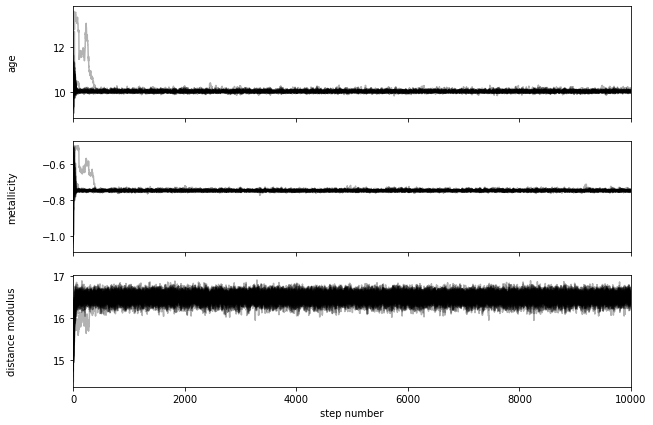

In [ ]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["age", "metallicity", "distance modulus"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [ ]:
# Use this to help figure out how much burn-in time to discard
tau = sampler.get_autocorr_time()
print(tau)

In [ ]:
# Thin by half the autocorrelation time
flat_samples = sampler.get_chain(discard=1000, thin=200, flat=True)
print(flat_samples.shape)

(1440, 3)


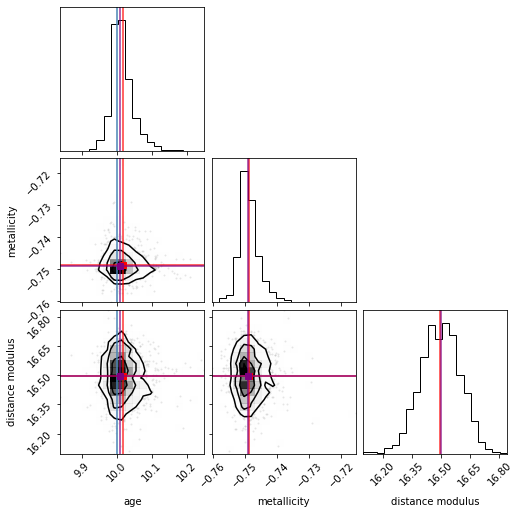

In [ ]:
fig = corner.corner(flat_samples, labels=labels, truths=start_guess) # blues are start guess
corner.overplot_lines(fig, np.mean(flat_samples, axis=0), color="red", alpha=0.8) # red are means
corner.overplot_points(fig, np.mean(flat_samples, axis=0)[None], marker="s", color="red")
corner.overplot_lines(fig, np.median(flat_samples, axis=0), color="purple", alpha=0.8) # purples are median
corner.overplot_points(fig, np.median(flat_samples, axis=0)[None], marker="s", color="purple")

In [ ]:
from IPython.display import Math

end_median=np.zeros(3)

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
    end_median[i] = mcmc[1]

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

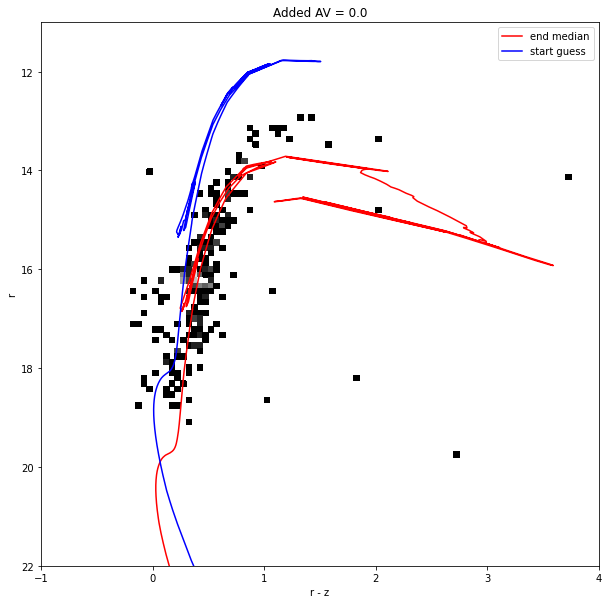

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(10,10))

plt.hist2d(datcol,datmag,bins=100,cmin=1,cmap='gist_gray',range=[[-1, 4], [11, 22]])

[age, feh, dmod] = end_median
isoch = mist.isochrone(np.log10(age)+9, feh, distance=10.0**(dmod/5 + 1), AV=0, eep_range=(200,1400))
ax.plot(isoch['DECam_'+band1+'_mag']-isoch['DECam_'+band2+'_mag'],isoch['DECam_'+band1+'_mag'],color='red',label='end median')

[age, feh, dmod] = start_guess
isoch = mist.isochrone(np.log10(age)+9, feh, distance=10.0**(dmod/5 + 1), AV=0, eep_range=(200,1400))
ax.plot(isoch['DECam_'+band1+'_mag']-isoch['DECam_'+band2+'_mag'],isoch['DECam_'+band1+'_mag'],color='blue',label='start guess')

ax.set_title('Added AV = '+str(np.round(np.mean(fakeAV),2)))

fig.gca().invert_yaxis()    
plt.xlabel(band1+' - '+band2)
plt.ylabel(band1)
ax.legend()
fig.show()

In [ ]:
for i in range(ndim):
    mcmc = np.round(np.percentile(flat_samples[:, i], [16, 50, 84]),2)
    q = np.round(np.diff(mcmc),2)
    print('$'+str(mcmc[1])+'_{-'+str(q[0])+'}^{+'+str(q[1])+'}$ |')

$10.01_{-0.02}^{+0.03}$ |
$-0.75_{-0.0}^{+0.0}$ |
$16.5_{-0.11}^{+0.1}$ |


**NOTE!  THIS IS AGE, NOT LOG(AGE)**

**NOTE!  THIS IS DISTANCE MODULUS, NOT DISTANCE**
